# PVSyst Backtracking Algorithm Comparison with bifacial_radiance 
#### (bifacial_radiance uses pvlib but modifies for sunrise/sunset hours)

Sanity check for what PVSyst is doing with the "Rotation Limits" and "Backtracking limit angle". It seems to me it's the 
same as ignoring the "backtracking limit angle" altogether with the Lorenzo backtracking algorithm.

PVSyst:
<ul>
    <li>VC0: tracking limit to 69.5 and backtracking limit angle to 69.4. Description on Journal 10. imported as df1.
    <li>VC1: tracking limit to 60, and backtracking limit angle to 69.4. Description on Journal 10. imported as df2.
</ul>
PVlib:
<ul>
    <li>trackign1: limitangle = 60</li>
    <li>tracking2: limitangle = 69.4</li>
    <li>tracking3: limitangle = 69.4, set rotation limit to 60 as per https://forum.pvsyst.com/viewtopic.php?t=3605</li>
    </ul>


In [1]:
import matplotlib.pyplot as plt
import pvlib
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = (10, 4)


## Site parameters (Site 3, Journal 10)

In [2]:
# Axapusco, Mexico
lat = 19.76
lng = -98.68
elev = 2385 #  https://es.wikipedia.org/wiki/Municipio_de_Axapusco
gcr = 0.35
axis_tilt = 0
axis_azimuth = 180
limit_angle = 60
limit_angle2 =69.4
backtrack = True
tz = 'America/Mexico_City'

In [3]:
def definePVsystOutputDecoder():
    
    PVsystOutputDecoder = {'NormFac' : 'Normalised performance index (ref. to STC)',
    'Yr' : 'Reference Incident Energy in coll. Plane',
    'Ya' : 'Normalized Array Production',
    'Yf' : 'Normalized System Production',
    'Lc' : 'Normalized Array Losses',
    'Ls' : 'Normalized System Losses',
    'Lcr' : 'Array Loss / Incident Energy Ratio',
    'Lsr' : 'System Loss / Incident Enregy Ratio',
    'PR' : 'Performance Ratio',
    'Effic' : 'Efficiencies',
    'EffArrR' : 'Effic. Eout array / rough area',
    'EffArrC' : 'Effic. Eout arra / cells area',
    'EffSysR' : 'Effic. Eout system / rough area',
    'EffSysC' : 'Effic Eout system / cells area',
    'EffInvB' : 'Inverter effic., threshold loss included',
    'EffInvR' : 'Inverter efficiency (operating)',
    'System' : 'System Operating Conditions',
    'Syst_ON' : 'System operating duration',
    'EOutInv' : 'Available Energy at Inverter Output',
    'E_Grid' : 'Energy injected into grid',
    'Invert' : 'Inverter Losses',
    'InvLoss' : 'Global inverter losses',
    'IL_Oper' : 'Inverter Loss during operation(efficiency)',
    'IL_Pmin' : 'Inverter Loss due to power threshold',
    'IL_Vmin' : 'Inverter Loss due to voltage threshold',
    'IL_Pmax' : 'Inverter Loss over nominal inv. Power',
    'IL_Vmax' : 'Inverter Loss over nominal inv. Voltage',
    'IL_Imax' : 'Inverter Loss due to max. input current',
    'Array' : 'PV array (field behaviour)',
    'EArrRef' : 'Array refernece energy for PR',
    'EArrNom' : 'Array nominal energy (at STC effic.)',
    'GIncLss' : 'PV loss due to irradiance level',
    'TempLss' : 'PV loss due to temperature',
    'OP_Pmin' : 'No Description',
    'OP_Pmax' : 'No Description',
    'OP_Oper' : 'No Description',
    'ModQual' : 'Module quality loss',
    'LIDLoss' : 'LID - Light induced degradation',
    'MisLoss' : 'Module array mismatch loss',
    'MismBak' : 'Mismatch for back irradiance',
    'OhmLoss' : 'Ohmic wiring loss',
    'EArrMPP' : 'Array virtual energy at MPP',
    'EArray' : 'Effective energy at the output of the array',
    'TExtON' : 'Average Ambient Temperature during running',
    'TArray' : 'Average Module Temperature during running',
    'TArrWtd' : 'Module Temper., weighted by GlobInc',
    'DTArr' : 'Temper. Difference modules-ambient during running',
    'DTArrGl' : 'DTArr weighted by "effective" incident Global',
    'IArray' : 'Array Current',
    'UArray' : 'Array Voltage',
    'ArrayON' : 'Duration of the PV production of the array',
    'IncFact' : 'Incident energy factors',
    'FTransp' : 'Transpostiion factor GlobInc / GlobHor',
    'FShdGl' : 'Near Shading Factor on global',
    'FShdBm' : 'Near Shading Factor on beam',
    'FShdDif' : 'Near Shading Factor on sky diffuse',
    'FShdAlb' : 'Near Shading Factor on albedo',
    'FIAMGl' : 'IAM factor on global',
    'FIAMBm' : 'IAM factor on beam',
    'FIAMDif' : 'IAM facotr on sky diffuse',
    'FIAMAlb' : 'IAM factor on albedo',
    'FSlgGl' : 'Soiling loss factor',
    'FSlgBm' : 'Soiling factor on beam',
    'FSlgDif' : 'Soiling loss factor on diffuse',
    'FSlgAlb' : 'Soiling loss factor on albedo',
    'FIAMShd' : 'Combined IAM and shading factors on global',
    'FEffDif' : 'IAM and shading factors on diffuse',
    'FEffAlb' : 'IAM and shading factors on albedo',
    'Angles' : 'Solar geometry',
    'HSol' : 'Sun height',
    'AzSol' : 'Sun azimuth',
    'AngInc' : 'Incidence angle',
    'AngProf' : 'Profile angle',
    'PhiAng' : 'Tracking: phi angle',
    'Transpo' : 'Transposition Variables',
    'BeamTrp' : 'Beam, Transposed',
    'DifITrp' : 'Diffuse Isotropic, Transposed',
    'CircTrp' : 'Circumsolar, Transposed',
    'HBndTrp' : 'Horizon Band, Transposed',
    'AlbTrp' : 'Albedo, Transposed',
    'GlobTrp' : 'Global, Tranpsosed',
    'MetData' : 'Meteorological Data',
    'GlobHor' : 'Horizontal global irradiation',
    'DiffHor' : 'Horizontal diffuse irradiation',
    'BeamHor' : 'Horizontal beam irradiation',
    'T_Amb' : 'T amb.',
    'WindVel' : 'Wind velocity',
    'IncColl' : 'Incident irradiance in collector plane',
    'GincThr' : 'Global incident below threshold',
    'GlobInc' : 'Global incident in coll. Plane',
    'BeamInc' : 'Beam incident in coll. Plane',
    'DifSInc' : 'Sky Diffuse incident in coll. Plane',
    'Alb_Inc' : 'Albedo incident in coll. Plane',
    'Bm_Gl' : 'Incident Beam / Global ratio',
    'DifA_Gl' : 'Incident Diffuse / Global ratio',
    'DifS_Gl' : 'Incident Sky Diffuse / Global ratio',
    'Alb_Gl' : 'Incident Albedo / Global ratio',
    'GlobShd' : 'Global corrected for shading',
    'ShdLoss' : 'Near shadings loss',
    'ShdBLss' : 'Near shadings beam loss',
    'ShdDLss' : 'Near shadings diffuse loss',
    'ShdALss' : 'Near shadings albedo loss',
    'GlobIAM' : 'Global corrected for incidente (IAM)',
    'IAMLoss' : 'Incidence (IAM) loss',
    'IAMBLss' : 'Incidence beam loss',
    'IAMDLss' : 'Incidence diffuse loss',
    'IAMALss' : 'Incidence albedo loss',
    'GlobSlg' : 'Global corrected for soiling',
    'SlgLoss' : 'Soiling loss',
    'SlgBLss' : 'Soiling beam loss',
    'SlgDLss' : 'Soiling diffuse loss',
    'SlgALss' : 'Soiling albedo loss',
    'GlobEff' : 'Effective Global, corr. For IAM and shadings',
    'BeamEff' : '"Effective" Beam, corr. For IAM and shadings',
    'DiffEff' : 'Effective Diffuse, corr. For IAM shadings',
    'Alb_Eff' : '"Effective" Albedo, corr. For IAM and shadings',
    'GlobGnd' : 'Global incident on ground',
    'ReflLss' : 'Ground reflection loss (albedo)',
    'BkVFLss' : 'View Factor for rear side',
    'DifSBak' : 'Sky diffuse on the rear side',
    'BackShd' : 'Shadings loss on rear side',
    'GlobBak' : 'Global Irradiance on rear side',
    'ReflFrt' : 'Ground reflection on front side',
    'ReflBck' : 'Ground reflection on back side',
    'BmIncBk' : 'Beamincident on the rear side',
    'BmSFBak' : 'Beam shading factor on the rear side',
    'BIAMFBk' : 'Beam IAM factor on the rear side',
    'BeamBak' : 'Beam effective on the rear side'}

    return PVsystOutputDecoder

def readPVSystOutputFile(filename):
    '''
    Reads a PVSYSt hourly output file, puts it in dataframe format and returns a 
    column header decoder to understand all the variables that name the columns.
    Also returns any metadata included in the file.
    
    Input
    -----
    filename       PVsyst hourly simulation output file(.csv)
    
    Returns
    -------
    df             Dataframe with the hourly simulation results. Columns are named for each variable.
    columnheaders  Decoder for the column header names, which are variables. This ties the available columns with the description of that variable.
    metdata        metdata included in the pvsyst file.
    
    '''
    
    import pandas as pd
    import csv
    
    f = open(filename)
    
    # Save metdata from file
    metdata=[]
    for i in range(10):  # skip the first 13 lines that are useless for the columns definition
        metdata.append(f.readline())  # use the resulting string for metadata extraction
      
    headers = f.readline().split(";")
    headers[-1] = headers[-1].strip()

    units = f.readline().split(";")
    units[-1] = units[-1].strip()

    PVsystOutputDecoder = definePVsystOutputDecoder()
    
    # Creating a dictionary for headers, units and their definition
    columnheaders = {}    
    for i in range (1, len(headers)):
        columnheaders[headers[i]] = {'Definition' : PVsystOutputDecoder[headers[i]],
                     'Units': units[i]}
    
    df = pd.read_csv(f, sep=";", names=headers)   
    df.index = pd.to_datetime(df['date'], dayfirst=True)
    
    return df, columnheaders, metdata

In [4]:
df1 = r'C:\Users\sayala\Desktop\Costal\PVSyst\UserHourly\Costal3_VC0_HourlyRes_0.CSV'  #  Orientation > Tracker Limit 69.4
df2 = r'C:\Users\sayala\PVsyst680_Data\UserHourly\Costal3_VC1_HourlyRes_0.CSV'  # Orientation > Tracker limit 60 

df1,columnheaders1,pvsyst_metdata1 = readPVSystOutputFile(df1)
df2,columnheaders2,pvsyst_metdata2 = readPVSystOutputFile(df2)

#df1 = df1.tz_localize('Etc/GMT-6')
#df2 = df2.tz_localize('Etc/GMT-6')
df1 = df1.tz_localize(tz)
df2 = df2.tz_localize(tz)

## SIMPLIFIED Sun Position

Not really using this one, because it's not the one bifacial_radiance is using

In [5]:
tz = 'America/Mexico_City'
times = pd.date_range('1990-01-01 00:00:00', '1991-01-01', closed='left', freq='H', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, lat, lng)

# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation'] > 0, :]

trackingdata = pvlib.tracking.singleaxis(solpos['zenith'],
                                         solpos['azimuth'],
                                         axis_tilt,
                                         axis_azimuth,
                                         limit_angle,
                                         backtrack,
                                         gcr)

C:\ProgramData\Anaconda3\lib\site-packages\pvlib\tracking.py:568: RuntimeWarning: invalid value encountered in remainder
  surface_azimuth = surface_azimuth % 360


## IMPROVED SUNRISE/SUNSET Sun Position

In [12]:
times = pd.date_range('1990-01-01 00:00:00', '1991-01-01', closed='left', freq='H', tz=tz)

interval = times[1]-times[0]

print("Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos")
print("This is what SAM and PVSyst do since May 2019.")

sunup= pvlib.irradiance.solarposition.sun_rise_set_transit_spa(times, lat, lng) 

sunup['minutedelta']= int(interval.seconds/2/60) # default sun angle 30 minutes after timestamp
# vector update of minutedelta at sunrise
sunrisemask = sunup.index.hour==sunup['sunrise'].dt.hour
sunup['minutedelta'].mask(sunrisemask,np.floor((60-(sunup['sunrise'].dt.minute))/2+(sunup['sunrise'].dt.minute)),inplace=True)
# vector update of minutedelta at sunset
sunsetmask = sunup.index.hour==sunup['sunset'].dt.hour
sunup['minutedelta'].mask(sunsetmask,np.floor((sunup['sunset'].dt.minute)/2),inplace=True)
# save corrected timestamp
sunup['corrected_timestamp'] = sunup.index+pd.to_timedelta(sunup['minutedelta'], unit='m')

solpos = pvlib.irradiance.solarposition.get_solarposition(sunup['corrected_timestamp'],lat,lng,elev)   
solpos['Sun position time'] = solpos.index
solpos.index = times

trackingdata = pvlib.tracking.singleaxis(solpos['zenith'],
                                         solpos['azimuth'],
                                         axis_tilt,
                                         axis_azimuth,
                                         limit_angle,
                                         backtrack,
                                         gcr)

trackingdata2 = pvlib.tracking.singleaxis(solpos['zenith'],
                                         solpos['azimuth'],
                                         axis_tilt,
                                         axis_azimuth,
                                         limit_angle2,
                                         backtrack,
                                         gcr)

Calculating Sun position with a delta of +30 mins. i.e. 12 is 12:30 sunpos
This is what SAM and PVSyst do since May 2019.


C:\ProgramData\Anaconda3\lib\site-packages\pvlib\tracking.py:449: RuntimeWarning: invalid value encountered in arccos
  wc = np.degrees(np.arccos(temp))
C:\ProgramData\Anaconda3\lib\site-packages\pvlib\tracking.py:473: RuntimeWarning: invalid value encountered in arccos
  aoi = np.degrees(np.arccos(np.abs(np.sum(sun_vec*panel_norm, axis=0))))
C:\ProgramData\Anaconda3\lib\site-packages\pvlib\tracking.py:568: RuntimeWarning: invalid value encountered in remainder
  surface_azimuth = surface_azimuth % 360
C:\ProgramData\Anaconda3\lib\site-packages\pvlib\tracking.py:572: RuntimeWarning: invalid value encountered in arccos
  surface_tilt = 90 - np.degrees(np.arccos(dotproduct))


## Applying The Rotation Limitation to the Backtracking Limit Angle

In [7]:
tracking3 = trackingdata2.copy() 
tracking3[tracking3 > 60] = 60
tracking3[tracking3 < -60] = -60

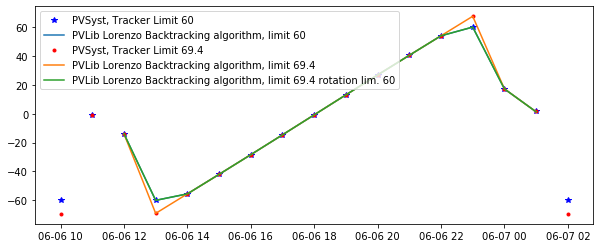

In [11]:
t1S = '1990-06-06 3:0:0'
t2S = '1990-06-06 21:0:0'

x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

foo1 = df1[(df1.index>t1S) & (df1.index<t2S)]
foo2 = df2[(df2.index>t1S) & (df2.index<t2S)]
foo3 = trackingdata[(trackingdata.index>t1S) & (trackingdata.index<t2S)]
foo4 = trackingdata2[(trackingdata2.index>t1S) & (trackingdata2.index<t2S)]
foo5 = tracking3[(tracking3.index>t1S) & (tracking3.index<t2S)]

plt.plot(foo2['PhiAng'], 'b*', label='PVSyst, Tracker Limit 60')
plt.plot(foo3['tracker_theta'], label='PVLib Lorenzo Backtracking algorithm, limit 60')
plt.plot(foo1['PhiAng'], 'r.', label='PVSyst, Tracker Limit 69.4')
plt.plot(foo4['tracker_theta'], label='PVLib Lorenzo Backtracking algorithm, limit 69.4')
plt.plot(foo5['tracker_theta'], label='PVLib Lorenzo Backtracking algorithm, limit 69.4 rotation lim. 60')
plt.legend()